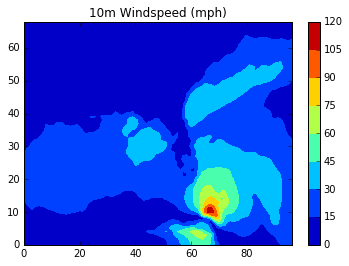

varname: T2 not found in dataset: wrfoutdiagnostics_d01_2017-09-09_12:00:00


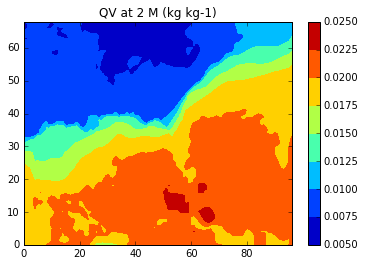

varname: DON not found in dataset: wrfoutdiagnostics_d01_2017-09-09_12:00:00
Failed to open: /this/is/a/bogus/dataset.nc


In [2]:
%matplotlib inline

import os

import numpy as np
import matplotlib.pyplot as plt

import netCDF4
   
def create_wind_diagnostics(wrfout_filepath, wrfdiag_filepath):
    

    """
    Creates a new NetCDF file that has attributes and dimensions 
    of the original wrfout file, and additionally has a 
    diagnostic variable, WS10 (10 meter windspeed), which has the
    same dimensions as U10 and V10 from the original wrfout file
    
    wrfout_filepath: path to the original wrfout NetCDF file
    wrfdiag_filepath: path to the newly created NetCDF diagnostic file
    """

    METERS_PER_SECOND_TO_MILES_PER_HOUR = 2.24
    
    # Open original for reading and new diagnostic for writing
    wrfout_dataset = netCDF4.Dataset(wrfout_filepath, 'r')    
    
    # If newfile already exists, remove it to avoid potential
    # permission problems
    if os.path.isfile(wrfdiag_filepath):
        os.remove(wrfdiag_filepath)
    wrfdiag_dataset = netCDF4.Dataset(wrfdiag_filepath, 'w')    
    
    # Write the same dimensions to the diagnostic dataset
    for the_key in wrfout_dataset.dimensions.keys():
        the_value = wrfout_dataset.dimensions[the_key].size
        the_name = wrfout_dataset.dimensions[the_key].name
        wrfdiag_dataset.createDimension(the_name, the_value)
    
    #  Write the global attributes to diagnostic file
    for attr in wrfout_dataset.ncattrs():
        attr_value = getattr(wrfout_dataset, attr)
        setattr(wrfdiag_dataset, attr, attr_value)

    # Now let's get U10 and V10 so that we can create S10     
    # Surface wind components
    U10 = wrfout_dataset.variables['U10'][:]
    V10 = wrfout_dataset.variables['U10'][:]    

    S10 = np.sqrt(U10**2 + V10**2) * METERS_PER_SECOND_TO_MILES_PER_HOUR

    # Write the S10 variable to the diagnostic file
    s10 = wrfdiag_dataset.createVariable('WS10', np.float32, 
                                     ('Time', 'south_north', 'west_east'))
    s10.units = "mph"
    s10.description = "10m Windspeed"
    s10[:] = S10    
           
    wrfout_dataset.close()
    wrfdiag_dataset.close()
    
    
def plot_wrf2dvar(wrfnc_filepath, varname):
    
    """
    Plots the 2D slice from the variable varname found in the
    NetCDF file wrfnc_filepath
    
    We will assume that the selected variable name, if present, 
    has dimensions (Time, south_north, west_east)
    
    wrfnc_filepath: NetCDF filename
    varname: variable name in the NetCDF file.  We will assume that
    this variable name, if present, has dimensions (Time, south_north,
    west_east)
    """
    
    try:
        dataset = netCDF4.Dataset(wrfnc_filepath, 'r')
    except:
        print("Failed to open: " + str(wrfnc_filepath))
        return None
    
    
    if varname not in dataset.variables.keys():
        print('varname: ' + str(varname) + ' not found in dataset: ' + str(wrfnc_filepath))
        return None
    
    # If we made it here, we found the variable name in the
    # dataset, so we assume dimensions are good and plot it.
    the_var = dataset.variables[varname]
    units = the_var.units
    description = the_var.description
    data = the_var[:]

    title = description + ' (' + units + ')'
    plt.contourf(data[0,:,:])
    plt.title(title)
    plt.colorbar()
    plt.show()    
    
    
    dataset.close()



# Open the old file and get its basic attributes for writing to the new file
WRFOUT_FILE_PATH = '/home/huscicomp/git/hu_cisc601_lu2018/NetCDFPlay/nonversioned_data/'
WRFOUT_FILE_PATH += 'Irmawrfout/wrfout_d01_2017-09-09_12:00:00'

WRFDIAG_PATH = 'wrfoutdiagnostics_d01_2017-09-09_12:00:00'    
    
    
create_wind_diagnostics(wrfout_filepath=WRFOUT_FILE_PATH, 
                        wrfdiag_filepath=WRFDIAG_PATH)    

# Call plot_wrf2dvar, have it try to plot DON, T2, WS10
plot_wrf2dvar(wrfnc_filepath=WRFDIAG_PATH, varname='WS10')
plot_wrf2dvar(wrfnc_filepath=WRFDIAG_PATH, varname='T2')
plot_wrf2dvar(wrfnc_filepath=WRFOUT_FILE_PATH, varname='Q2')
plot_wrf2dvar(wrfnc_filepath=WRFDIAG_PATH, varname='DON')
plot_wrf2dvar(wrfnc_filepath='/this/is/a/bogus/dataset.nc', varname='T2')